In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
%matplotlib inline

In [2]:
data = np.load("DK_time_series_for_new_loss.npy")
data = data[0] + data[3]

train = data[:10000]
test =  data[10000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [90]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+1:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [91]:
train_dataloader = DataLoader(train_inout_seq, batch_size=10, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_inout_seq, batch_size=10, shuffle=True, drop_last=True)

In [192]:
class LaplacianSmoothing(nn.Module):   
    def __init__(self, n_iter=1, gamma=0.5):
        super(LaplacianSmoothing, self).__init__() 
        self.n_iter = n_iter
        self.gamma = gamma
        
        
    def forward(self, x):
        x = x[:, :, 0]
        x = torch.permute(x, (1, 0))
        #print("X shape", x.size())
        x_new = torch.zeros_like(x).to('cuda')
        for ind, batch in enumerate(x):
            A = torch.zeros((train_window, train_window)).to('cuda')
            #print("A shape", A.size())
            for i, first in enumerate(batch):
                for j, second in enumerate(batch):
                    A[i][j] = torch.abs(first - second)
                    
            #print("A", A)
            A = A / (torch.sum(A, axis=1, keepdims=True))
            
            #print("A norm", A)
            #print("A0 sum", A[0].sum())
            #print("A1 sum", A[1].sum())
            
            x_new[ind] = (1 - self.gamma) * x[ind] + self.gamma * (A @ x[ind])
            
            
        #print("x_new shape", x_new.size())
        
        x_new = x_new.reshape((x.size()[0], train_window, 1))
        x_new = torch.permute(x_new, (1, 0, 2))
        #print("x_new shape", x_new.size())
    
        return x_new 
        
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
    
        return x + self.pe[:x.size(0), :]
          

class TransAm(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.laplacian_smoothing = LaplacianSmoothing()
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        src = self.laplacian_smoothing(src)
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        
        #print(src.size())
        src = self.pos_encoder(src)
        #print(src.size())

        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        #print(output.size())
        
        output = self.decoder(output)
        #print(output.size())
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# Example

In [166]:
# example = torch.tensor([[1., 2., 3.] ,
#                         [2., 3, 4]], 
#                          )

In [94]:
# example

In [95]:
# lc = LaplacianSmoothing()
# train_window = 3
# batch_size = 2

In [88]:
# lc(example)

X shape torch.Size([2, 3])
A shape torch.Size([3, 3])
A tensor([[0., 1., 2.],
        [1., 0., 1.],
        [2., 1., 0.]])
A norm tensor([[0.0000, 0.3333, 0.6667],
        [0.5000, 0.0000, 0.5000],
        [0.6667, 0.3333, 0.0000]])
A0 sum tensor(1.)
A1 sum tensor(1.)
A shape torch.Size([3, 3])
A tensor([[0., 1., 2.],
        [1., 0., 1.],
        [2., 1., 0.]])
A norm tensor([[0.0000, 0.3333, 0.6667],
        [0.5000, 0.0000, 0.5000],
        [0.6667, 0.3333, 0.0000]])
A0 sum tensor(1.)
A1 sum tensor(1.)


tensor([[1.8333, 2.0000, 2.1667],
        [2.8333, 3.0000, 3.1667]])

In [193]:
model = TransAm().to('cuda')

In [194]:
from IPython.display import clear_output

In [195]:
input_window = 20

In [196]:
def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target

In [197]:
batch_size = 64

In [198]:
def run_epoch(train_data, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        if is_training:
            optimizer.zero_grad()
            
        #print(x.size())
        #print(y.size())
        #x = torch.transpose(x, 0, 1).reshape((20, 10, 1)).float().to('cuda')
        #y = y.view(-1).float().to('cuda')

        out = model(data.to('cuda'))
        loss = criterion(out, targets.to('cuda'))

        if is_training:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
            optimizer.step()

        epoch_loss += (loss.detach().item() / batch_size)

    #lr = scheduler.get_last_lr()[0]

    return epoch_loss

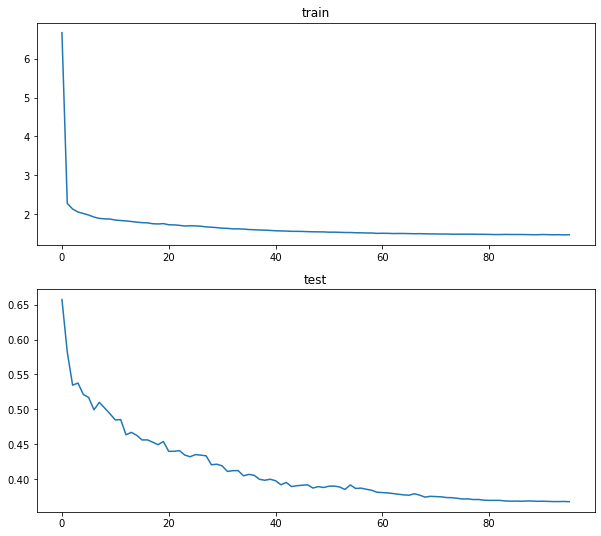

Epoch[96/200] | loss train:1.466731, test:0.367304


In [ ]:
criterion = nn.MSELoss()
lr = 0.005 
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer,  1.0, gamma=0.95)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train = run_epoch(train_inout_seq, is_training=True)
    loss_val = run_epoch(test_inout_seq)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val))

In [14]:
def ShowPredict(model1, k):
    #train_dataloader = DataLoader(train_inout_seq, batch_size=64, shuffle=True, drop_last=True)
    #val_dataloader = DataLoader(test_inout_seq, batch_size=64, shuffle=False, drop_last=True)
    test_right_part = (len(test)- 20)%64
    predicted_val = np.array([])
    for batch, i in enumerate(range(0, len(test_inout_seq) - 1, batch_size)):
        data, targets = get_batch(test_inout_seq, i,batch_size)
        if data.size()[1] < 64:
            break
        cur_x = data
        for _ in range(k):
            out = model1(cur_x.to('cuda'))
            #cur_x = torch.hstack((cur_x[:, 1:], out.cpu()))
            cur_x = torch.vstack((cur_x[1:, :], out[-1].cpu().reshape((1, 64, 1))))
        #out = model1(cur_x.to('cuda'))
        #predicted_val = np.concatenate((predicted_val, out[-1, :, 0].cpu().detach().numpy()))
        predicted_val = np.concatenate((predicted_val, cur_x[-1, :, 0].cpu().detach().numpy()))
        
        
    if k == 1:
        r = (((np.array(predicted_val)*std+mean - np.array(test[20:-test_right_part]))**2).mean())**0.5
    else:
        r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(test[20+k-1:-test_right_part]))**2).mean())**0.5
    print("RMSE is ", r)
        
    fig = plt.figure(figsize=(16, 12))
        
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_1.plot(test_norm[20+k-1:], label='true')
    if k == 1:
        ax_1.plot(predicted_val[:],  linestyle = '--', label='predicted')
    else:
        ax_1.plot(predicted_val[:-k+1],  linestyle = '--', label='predicted')
    ax_1.legend()
    
    
    plt.show()

RMSE is  0.44090755562850253


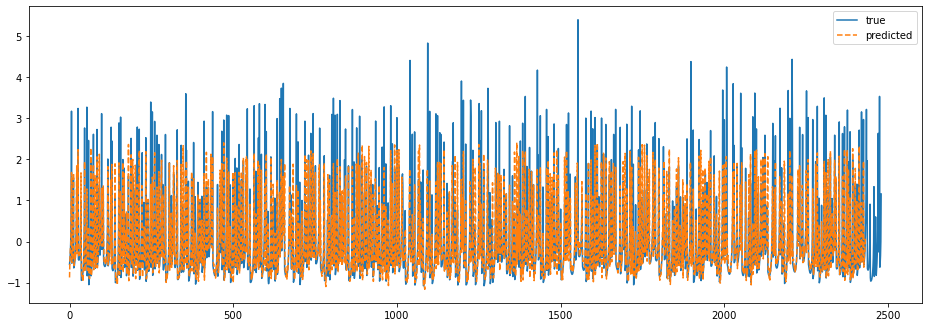

In [15]:
ShowPredict(model, 1)

In [16]:
def GetRmse(model, train_dataloader, val_dataloader, test, std, mean):
    model.eval()

    rmse = []

    for k in range(1, 20):
        test_right_part = (len(test)- 20)%64
        predicted_val = np.array([])
        for batch, i in enumerate(range(0, len(test_inout_seq) - 1, batch_size)):
            data, targets = get_batch(test_inout_seq, i,batch_size)
            if data.size()[1] < 64:
                break
            cur_x = data
            for _ in range(k):
                out = model(cur_x.to('cuda'))
                #cur_x = torch.hstack((cur_x[:, 1:], out.cpu()))
                cur_x = torch.vstack((cur_x[1:, :], out[-1].cpu().reshape((1, 64, 1))))
            #out = model1(cur_x.to('cuda'))
            #predicted_val = np.concatenate((predicted_val, out[-1, :, 0].cpu().detach().numpy()))
            predicted_val = np.concatenate((predicted_val, cur_x[-1, :, 0].cpu().detach().numpy()))
        if k == 1:
            r = (((np.array(predicted_val)*std+mean - np.array(test[20:-test_right_part]))**2).mean())**0.5
        else:
            r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(test[20+k-1:-test_right_part]))**2).mean())**0.5
        rmse.append(r)
    return rmse

In [17]:
rmses = GetRmse(model, train_dataloader, test_dataloader, test, std, mean)

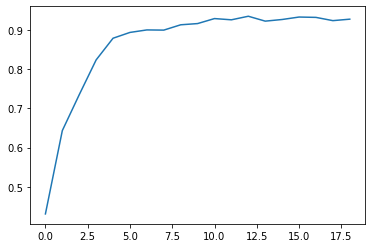

In [18]:
plt.plot(rmses)